<a href="https://colab.research.google.com/github/Heulwen31/LandCoverMappingUseSentinel2RandomForest/blob/main/LandCoverMappingUseSentinel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!pip install earthpy gdal 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Import library

In [46]:
from glob import glob
import sys
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')
import pandas as pd

from sklearn.model_selection import train_test_split


import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)


from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn import preprocessing

#Read data from sentinel 2

In [47]:
file_path = "/content/drive/MyDrive/AI/HCM_30m_ProjectRaster1.tif"

In [48]:
l = []

with rio.open(file_path, 'r') as f:
  for j in range(1,13): 
    l.append(f.read(j))

In [49]:
arr_st = np.stack(l)
print(arr_st.shape)
print(arr_st)

(12, 3006, 2478)
[[[-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  ...
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]]

 [[-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  ...
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]]

 [[-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  [-3

In [50]:
fill_null = arr_st[0][0][0]
arr_st = np.nan_to_num(arr_st, nan=fill_null)

#Use gdal read band image and convert coordinate to point

In [51]:
from osgeo import osr, ogr, gdal

tif = gdal.Open(file_path)
gt = tif.GetGeoTransform()

# convert coordinates to pixels
def world_to_pixel(geo_matrix, x, y):
    """
    Uses a gdal geomatrix (gdal.GetGeoTransform()) to calculate
    the pixel location of a geospatial coordinate
    """
    ul_x= geo_matrix[0]
    ul_y = geo_matrix[3]
    x_dist = geo_matrix[1]
    y_dist = geo_matrix[5]
    pixel = int((x - ul_x) / x_dist)
    line = -int((ul_y - y) / y_dist)
    return pixel, line

#read data from arr_st to fill 12 band in pandas table 
def read_band_from_tiff(x, y, data):
  a, b = world_to_pixel(gt, x, y)
  ls = []
  for i in range(12):
    ls.append(data[i, b, a])
  return ls
print(read_band_from_tiff(692570.3, 1158673, arr_st))

[0.06324, 0.08784667, 0.10897333, 0.10288667, 0.10225333, 0.06503333, 0.06739333, 0.059266668, 0.05274667, 0.047626667, 0.032353334, 0.028206667]


##Read data from excel


In [52]:
df = pd.read_excel('/content/drive/MyDrive/AI/Data.xlsx')
bands_list = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12']

ndvi = []
ndwi = []
#fill band to pandas 
for i in df.index: 
  l = read_band_from_tiff(df['X'][i], df['Y'][i], arr_st)
  ndvi.append((l[7]-l[3])/(l[7]+l[3]))
  ndwi.append((l[2]-l[7])/(l[2]+l[7]))
  for j in range(12):
    df[bands_list[j]][i] = l[j]
  
df['NDVI'] = ndvi
df['NDWI'] = ndwi

VL = arr_st[0][0][0]
for i in range(100):
  df.loc[len(df.index)] = [0.0, 0.0, 'None', VL, VL, VL, VL, VL, VL, VL, VL, VL, VL, VL, VL, 0.0, 0.0]
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in float_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in float_scalars
  # Remove the CWD from sys.path while we load stuff.


,X,Y,Label,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,NDVI,NDWI
0,692570.3,1158673.0,Open water,6.324000e-02,8.784667e-02,1.089733e-01,1.028867e-01,1.022533e-01,6.503333e-02,6.739333e-02,5.926667e-02,5.274667e-02,4.762667e-02,3.235333e-02,2.820667e-02,-0.269005,0.295451
1,701976.6,1170650.0,Open water,7.561143e-02,8.035429e-02,1.023914e-01,1.009857e-01,1.012771e-01,6.460571e-02,6.918000e-02,5.664286e-02,5.722857e-02,8.912857e-02,3.050571e-02,2.867714e-02,-0.281312,0.287665
2,702281.4,1165919.0,Open water,8.595143e-02,1.028914e-01,1.185343e-01,1.133971e-01,1.153914e-01,8.398572e-02,8.552000e-02,8.070286e-02,7.223714e-02,7.812285e-02,4.488286e-02,3.634286e-02,-0.168440,0.189881
3,692162.8,1169897.0,Open water,5.861765e-02,7.214706e-02,1.005059e-01,1.016588e-01,9.839412e-02,5.077647e-02,5.320588e-02,4.196471e-02,3.533529e-02,2.377059e-02,1.314706e-02,1.158824e-02,-0.415629,0.410900
4,715599.0,1156236.0,Open water,8.568500e-02,8.681500e-02,1.014300e-01,7.876000e-02,7.436500e-02,4.693500e-02,4.774500e-02,4.151000e-02,3.855500e-02,8.792000e-02,2.536500e-02,2.278000e-02,-0.309720,0.419197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17907,0.0,0.0,None,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.000000,0.000000
17908,0.0,0.0,None,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.000000,0.000000
17909,0.0,0.0,None,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.000000,0.000000
17910,0.0,0.0,None,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.000000,0.000000


In [53]:
class_names = df['Label'].unique()
label_encoder = preprocessing.LabelEncoder()
df['Label']= label_encoder.fit_transform(df['Label'])

In [64]:
array = df.values
X = array[:, 3:17]
y = array[:, 2]

# scale = StandardScaler()
# scale_X = scale.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
pipe = make_pipeline(RandomForestClassifier(max_depth=512, random_state=42))
test_predict = pipe.fit(X_train, y_train).predict(X_test)

In [66]:
print(classification_report(y_test, test_predict, target_names=class_names))

                  precision    recall  f1-score   support

      Open water       0.66      0.66      0.66       332
Residential Land       0.47      0.27      0.35       227
    Rice paddies       0.37      0.45      0.41       412
      Crop lands       0.52      0.55      0.54       341
      Grass land       0.57      0.57      0.57       120
    Barren land        0.95      1.00      0.97        19
     Scub/Schrub       0.90      0.87      0.89       222
          Forest       0.69      0.83      0.75       682
         Wetland       0.48      0.42      0.45       338
    Aquarculture       0.39      0.18      0.25       222
            None       0.87      0.89      0.88       668

        accuracy                           0.64      3583
       macro avg       0.63      0.61      0.61      3583
    weighted avg       0.63      0.64      0.63      3583



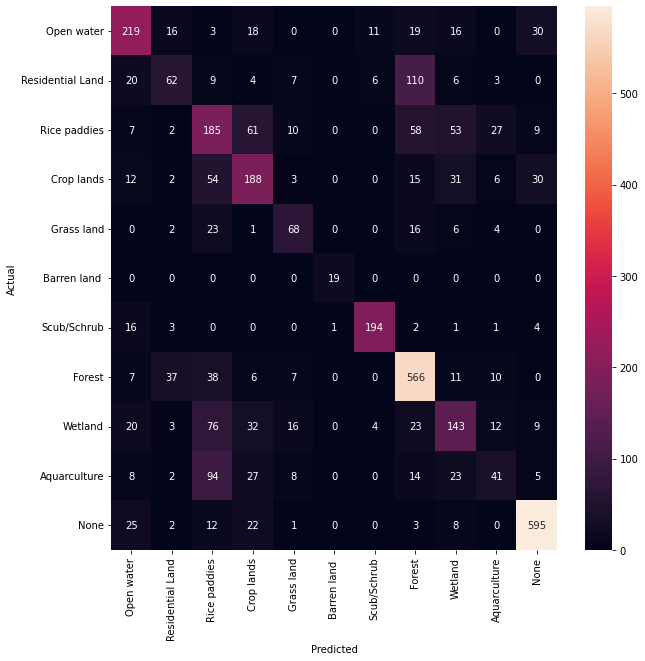

In [67]:
conf_mat = confusion_matrix(y_test, test_predict)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [58]:
df['Label'].value_counts()

7     3378
10    3378
2     2048
8     1689
3     1689
0     1689
6     1126
1     1126
9     1126
4      563
5      100
Name: Label, dtype: int64

# Create land cover mapping 


In [59]:
arr = []

for i in range(3006):
  for j in range(2478):
    ls = []
    for k in range(12):
      ls.append(arr_st[k][i][j])
    ls.append((ls[7]-ls[3])/(ls[7] + ls[3]))
    ls.append((ls[2]-ls[7])/(ls[2]+ls[7]))
    arr.append(ls)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in float_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in float_scalars
  if __name__ == '__main__':


In [60]:
arr = np.array(arr)
print(arr.shape)

(7448868, 14)


In [61]:
arr = np.nan_to_num(arr, nan=0)
arr = pipe.predict(arr)
arr = arr.reshape(3006, 2478)

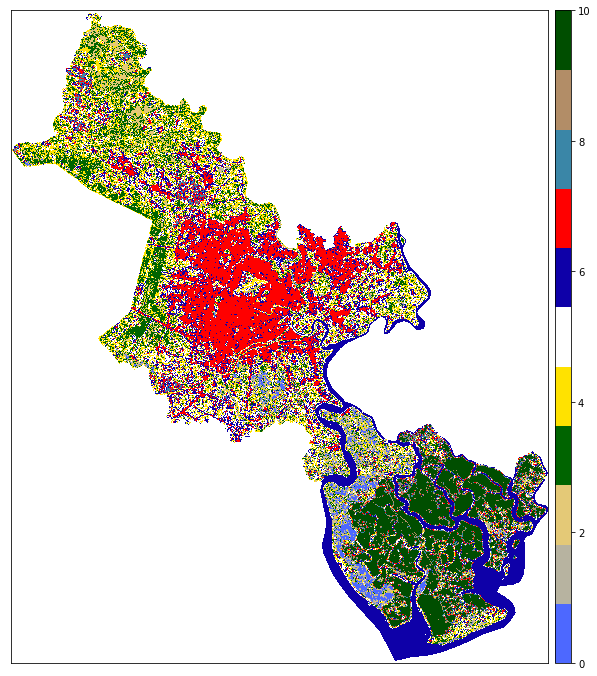

In [63]:
# target_names = {'Aquarculture': 0, 'Barren land ': 1,  
#                 'Crop lands': 2, 'Forest': 3,
#                 'Grass land': 4, 'None': 5,
#                 'Open water': 6, 'Residential Land': 7, 
#                 'Rice paddies': 8, 'Scub/Schrub': 9, 
#                 'Wetland': 10}

ep.plot_bands(arr.astype(float), cmap=ListedColormap(['#4d68ff', '#b7b3a0', 
                                                      '#e4c977', '#006400', 
                                                      '#ffe200', 'white', 
                                                      '#0e00a8', 'red', 
                                                      '#3a86a7', '#b28d67', 
                                                      '#004e00']))
plt.show()